In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import matplotlib as mpl
import utils

In [2]:
# loading the region data
with open('../../../../data/mike_working_dir/identifying_regions_data/adjusted_regions.pkl', 'rb') as f:
		regions = pickle.load(f)
with open('../../../../data/mike_working_dir/identifying_regions_data/twins_era_stats_dict_radius_regions_min_2.pkl', 'rb') as f:
		stats = pickle.load(f)

# loading the solar wind data
omni = pd.read_feather('../data/SW/omniData.feather')
omni = omni.set_index('Epoch', drop=True)
omni.index = pd.to_datetime(omni.index)

storm_list = pd.read_csv('StormList_types.csv')
storm_list['initial_phase'] = pd.to_datetime(storm_list['initial_phase'])
storm_list['main_phase'] = pd.to_datetime(storm_list['main_phase'])
storm_list['minimumSymH'] = pd.to_datetime(storm_list['minimumSymH'])
storm_list['end_recovery_phase'] = pd.to_datetime(storm_list['end_recovery_phase'])
storm_list['new_begining_times'] = pd.to_datetime(storm_list['new_begining_times'])
storm_list['new_ending_times'] = pd.to_datetime(storm_list['new_ending_times'])

In [3]:
region_numbers = [387, 61, 202, 287, 207, 361, 137, 184, 36, 19, 9, 163, 16, 270, 194, 82,
								83, 143, 223, 44, 173, 321, 366, 383, 122, 279, 14, 95, 237, 26, 166, 86,
								62, 327, 293, 241, 107, 55, 111, 400, 401]

regions = {f'region_{region}': regions[f'region_{region}'] for region in region_numbers}

In [4]:
for region in regions:
	regions[region]['mean_lat'] = utils.getting_mean_lat(regions[region]['station'])

Loading station SOD....
Loading station IVA....
Loading station MUO....
Loading station KIR....
Loading station PEL....
Loading station SOD....
Loading station IVA....
Loading station MUO....
Loading station PEL....
Loading station LON....
Loading station THY....
Loading station NCK....
Loading station P01....
Loading station THY....
Loading station BDV....
Loading station WIC....
Loading station NCK....
Loading station HRB....
Loading station VYH....
Loading station LON....
Loading station THY....
Loading station WIC....
Loading station NCK....
Loading station HRB....
Loading station P01....
Loading station VYH....
Loading station THY....
Loading station WIC....
Loading station NCK....
Loading station HRB....
Loading station ZAG....
Loading station VYH....
Loading station THY....
Loading station NCK....
Loading station HRB....
Loading station BEL....
Loading station HLP....
Loading station SZC....
Loading station KLD....
Loading station MEK....
Loading station HAN....
Loading station 

In [5]:
# defining the latitude bins in degrees
lat_delimiter = 5

lat_dict = {}
for i in range(20, 90, lat_delimiter):
	lat_dict[i] = {'rsd': pd.DataFrame()}
	for region in regions:
		if regions[region]['mean_lat'] > i and regions[region]['mean_lat'] < i + lat_delimiter:
			stats[region]['max_rsd'] = pd.concat([stats[region]['max_rsd'], omni], axis=1, join='inner')
			lat_dict[i]['rsd'] = pd.concat([lat_dict[i]['rsd'], stats[region]['max_rsd']], axis=0)

In [6]:
hss_df = storm_list[(storm_list['ifHSS'].isnull() == False) & (storm_list['ifCME'].isnull() == True)]
cme_df = storm_list[(storm_list['ifCME'].isnull() == False) & (storm_list['ifHSS'].isnull() == True)]
complex_df = storm_list[storm_list['ifcomplex'].isnull() == False]

In [38]:
def perc95(x):
	return np.percentile(x, 95)

def seperating_into_bins(lat_dict, dates=None, var=None, var_bins=None):

	# writing some error handling for the inputs
	if dates is not None:
		if not isinstance(dates, pd.DataFrame):
			raise ValueError('dates must be a pandas dataframe')
		if dates.shape[1] < 2:
			raise ValueError('dates must have column for start time and end time')

	if var:
		if not isinstance(var, str):
			raise ValueError('var must be a string')
		if not isinstance(var_bins, list):
			raise ValueError('var_bins must be a list')
		if len(var_bins) < 2:
			raise ValueError('var_bins must have at least two elements')

	# creating a dataframe to store the combined data
	if var:
		titles = []
		for i in range(len(var_bins)+1):
			if i == 0:
				titles.append(f'{var}<{var_bins[i]}')
			elif i < len(var_bins):
				titles.append(f'{var} between {var_bins[i-1]} and {var_bins[i]}')
			else:
				titles.append(f'{var}>{var_bins[i-1]}')
		combined_aggs = {t: pd.DataFrame() for t in titles}
	else:
		combined_aggs = pd.DataFrame()

	for lat in lat_dict:
		if lat_dict[lat]['rsd'].empty:
			continue
		lat_dict[lat]['rsd'].dropna(inplace=True)
		lat_dict[lat]['rsd']['MLT'] = lat_dict[lat]['rsd']['MLT'].astype(int)
		lat_dict[lat]['rsd']['MLT'].replace(24, 0, inplace=True)

		# if a dates dataframe is included, the data will be filtered to only
		# include the dates between the starting and ending dates for each row
		# of the dataframe
		if dates is not None:
			temp_df = pd.DataFrame()
			if isinstance(lat_dict[lat]['rsd'].index, pd.DatetimeIndex):
				lat_dict[lat]['rsd'].reset_index(inplace=True, drop=False)
				lat_dict[lat]['rsd'].rename(columns={'index': 'Date_UTC'}, inplace=True)
			lat_dict[lat]['rsd']['Date_UTC'] = pd.to_datetime(lat_dict[lat]['rsd']['Date_UTC'])
			df = lat_dict[lat]['rsd']
			for index, date in dates.iterrows():
				storm = df[(df['Date_UTC'] >= date['initial_phase']) & (df['Date_UTC'] <= date['end_recovery_phase'])][['max_rsd', 'MLT']]
				temp_df = pd.concat([temp_df, storm], axis=0)
			temp_df = temp_df.groupby('MLT').agg(['mean', 'std', 'max', 'median', perc95])['max_rsd']
			temp_df['lat'] = lat
			combined_aggs = pd.concat([combined_aggs, temp_df], axis=0)

		# if a variable is included, the data will be filtered to only include
		# the rows where the variable is between the values in the var_bins.
		# this will create n+1 dataframes where n is the number of bins
		if var:
			temp_df = lat_dict[lat]['rsd']
			for i, t in enumerate(titles):
				if i == 0:
					lat_dict[lat][t] = temp_df[temp_df[var] < var_bins[i]][['max_rsd', 'MLT']]
				elif i < len(var_bins):
					lat_dict[lat][t] = temp_df.loc[temp_df[var].between(var_bins[i-1], var_bins[i])][['max_rsd', 'MLT']]
				else:
					lat_dict[lat][t] = temp_df[temp_df[var] > var_bins[i-1]][['max_rsd', 'MLT']]

				lat_dict[lat][t] = lat_dict[lat][t].groupby('MLT').agg(['mean', 'std', 'max', 'median', perc95])['max_rsd']
				lat_dict[lat][t]['lat'] = lat
				combined_aggs[t] = pd.concat([combined_aggs[t], lat_dict[lat][t]], axis=0)

		# lat_dict[lat]['rsd']['lat'] = lat

	return lat_dict, combined_aggs

bz_lat_dict, bz_combined_aggs = seperating_into_bins(lat_dict, var='BZ_GSM', var_bins=[-2, 2])
vx_lat_dict, vx_combined_aggs = seperating_into_bins(lat_dict, var='Vx', var_bins=[-700, -400])
hss_lat_dict, hss_combined_aggs = seperating_into_bins(lat_dict, dates=hss_df[['initial_phase', 'end_recovery_phase']])
cme_lat_dict, cme_combined_aggs = seperating_into_bins(lat_dict, dates=cme_df[['initial_phase', 'end_recovery_phase']])
complex_lat_dict, complex_combined_aggs = seperating_into_bins(lat_dict, dates=complex_df[['initial_phase', 'end_recovery_phase']])

In [43]:
def plot_formatting(combined_aggs, stat_value, name=None):

	# creating a meshgrid to plot the pivot table values
	mltbin = np.arange(0, 24, 1)
	latbin = np.arange(50, 85, 5)

	arr = np.asarray(mltbin)/24.*2*np.pi
	R, th = np.meshgrid(latbin, arr)

	# creating the pivot table
	if isinstance(combined_aggs, pd.DataFrame):
		plotting_dict = {name:{}}
		pivot = combined_aggs.pivot_table(index='lat', columns='MLT', values=stat_value)

		# creating a 2d array using the pivot table values and the meshgrid and filling the rest with zeros
		Z = np.zeros((len(latbin), len(mltbin)), dtype=float)
		for i, lat in enumerate(latbin):
			for mlt in mltbin:
				try:
					Z[i, mlt] = pivot.loc[lat, mlt]
				except:
					Z[i, mlt] = np.nan

		plotting_dict[name]['Z'] = Z
		plotting_dict[name]['R'] = R
		plotting_dict[name]['th'] = th
		return plotting_dict

	elif isinstance(combined_aggs, dict):
		plotting_dict = {key:{} for key in combined_aggs.keys()}
		for key in combined_aggs:
			# creating the pivot table
			pivot = combined_aggs[key].pivot_table(index='lat', columns='MLT', values=stat_value)

			# creating a 2d array using the pivot table values and the meshgrid and filling the rest with zeros
			Z = np.zeros((len(latbin), len(mltbin)), dtype=float)
			for i, lat in enumerate(latbin):
				for mlt in mltbin:
					try:
						Z[i, mlt] = pivot.loc[lat, mlt]
					except:
						Z[i, mlt] = np.nan

			plotting_dict[key]['Z'] = Z
			plotting_dict[key]['R'] = R
			plotting_dict[key]['th'] = th

	else:
		raise ValueError('combined_aggs must be a pandas dataframe or a dictionary')

	return plotting_dict

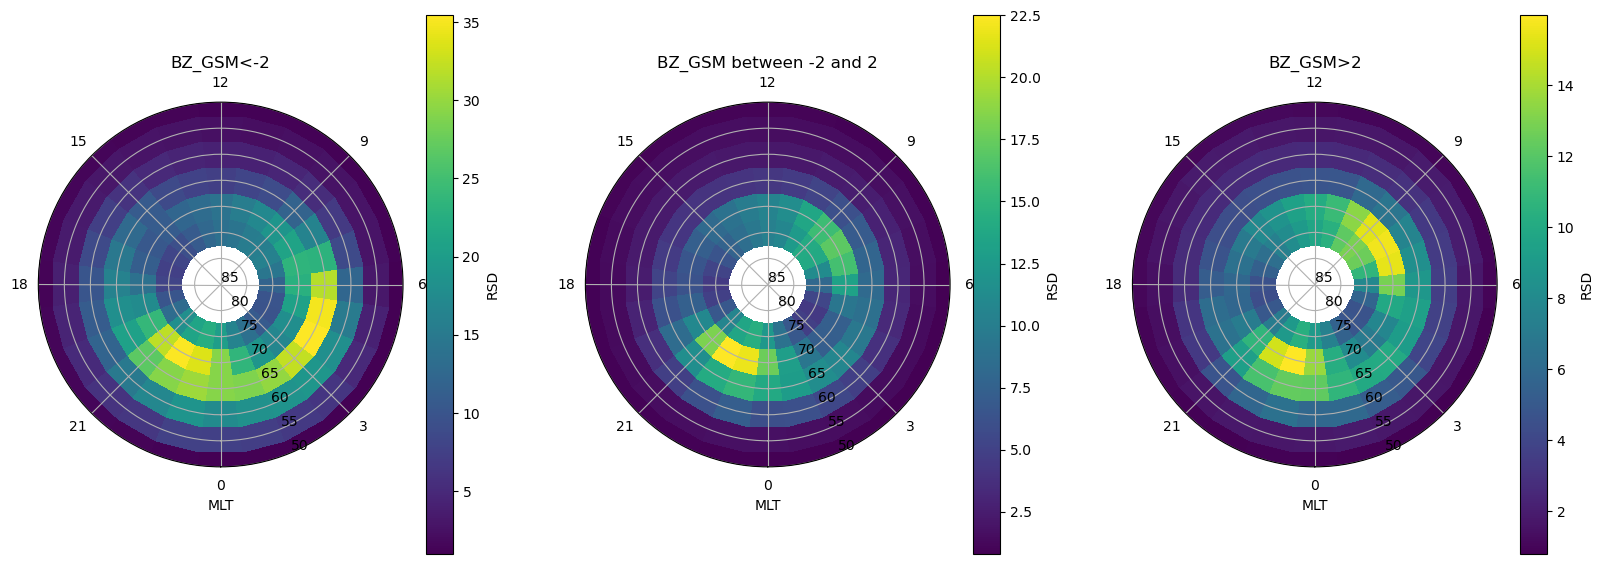

In [49]:
# plotting the heatmap using polar plot

plotting_dict = plot_formatting(bz_combined_aggs, 'perc95')
fig, ax = plt.subplots(1, len(plotting_dict), figsize=(20,7), subplot_kw=dict(projection='polar'))
for i, key in enumerate(plotting_dict):
	Z = plotting_dict[key]['Z']
	R = plotting_dict[key]['R']
	th = plotting_dict[key]['th']
	c = ax[i].pcolormesh(th, R, Z.T, cmap='viridis', shading='auto')
	fig.colorbar(c, ax=ax[i], label='RSD')
	ax[i].set_rlim(bottom=85, top=50)
	ax[i].set_theta_zero_location('S')
	ax[i].set_thetagrids([theta * 45 for theta in range(360//45)], labels=[0, 3, 6, 9, 12, 15, 18, 21])
	ax[i].set_xlabel('MLT')
	ax[i].set_title(key)

plt.show()

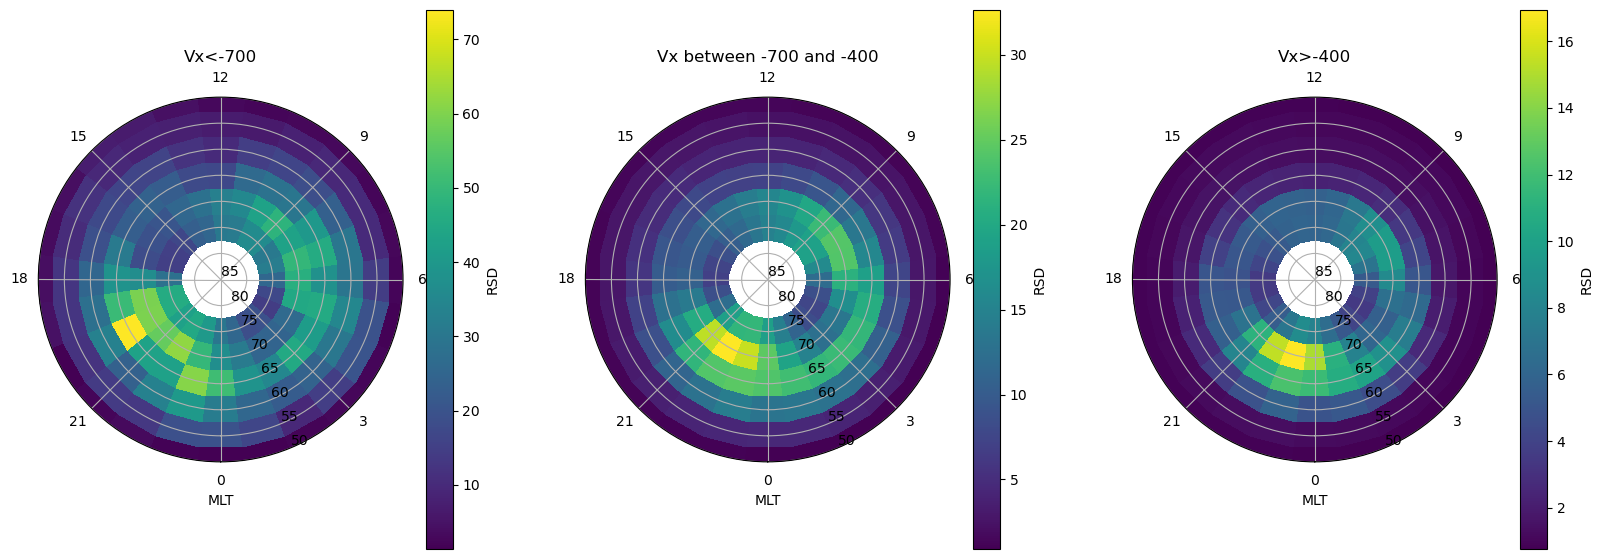

In [48]:
# plotting the heatmap using polar plot

plotting_dict = plot_formatting(vx_combined_aggs, 'perc95')
fig, ax = plt.subplots(1, len(plotting_dict), figsize=(20,7), subplot_kw=dict(projection='polar'))
for i, key in enumerate(plotting_dict):
	Z = plotting_dict[key]['Z']
	R = plotting_dict[key]['R']
	th = plotting_dict[key]['th']
	c = ax[i].pcolormesh(th, R, Z.T, cmap='viridis', shading='auto')
	fig.colorbar(c, ax=ax[i], label='RSD')
	ax[i].set_rlim(bottom=85, top=50)
	ax[i].set_theta_zero_location('S')
	ax[i].set_thetagrids([theta * 45 for theta in range(360//45)], labels=[0, 3, 6, 9, 12, 15, 18, 21])
	ax[i].set_xlabel('MLT')
	ax[i].set_title(key)

plt.show()

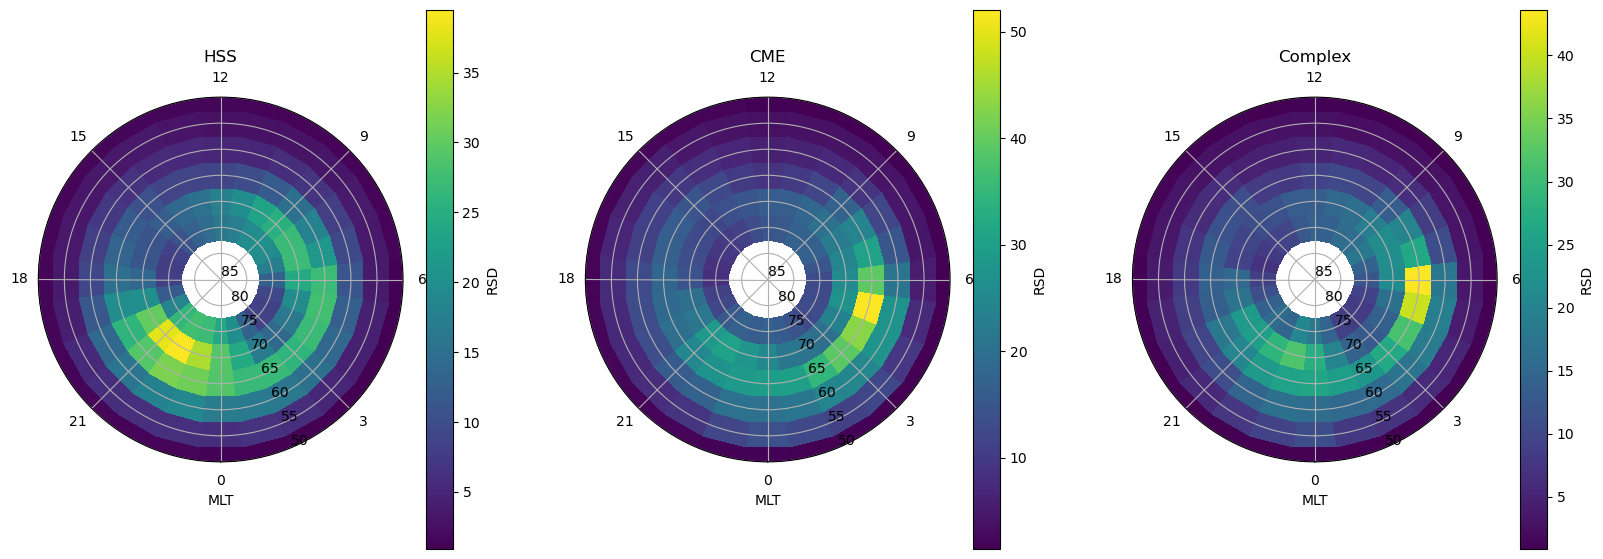

In [47]:
# plotting the heatmap using polar plot
hss_plotting_dict = plot_formatting(hss_combined_aggs, 'perc95', name='HSS')
cme_plotting_dict = plot_formatting(cme_combined_aggs, 'perc95', name='CME')
complex_plotting_dict = plot_formatting(complex_combined_aggs, 'perc95', name='Complex')
plotting_dict = {**hss_plotting_dict, **cme_plotting_dict, **complex_plotting_dict}
fig, ax = plt.subplots(1, len(plotting_dict), figsize=(20,7), subplot_kw=dict(projection='polar'))
for i, key in enumerate(plotting_dict):
	Z = plotting_dict[key]['Z']
	R = plotting_dict[key]['R']
	th = plotting_dict[key]['th']
	c = ax[i].pcolormesh(th, R, Z.T, cmap='viridis', shading='auto')
	fig.colorbar(c, ax=ax[i], label='RSD')
	ax[i].set_rlim(bottom=85, top=50)
	ax[i].set_theta_zero_location('S')
	ax[i].set_thetagrids([theta * 45 for theta in range(360//45)], labels=[0, 3, 6, 9, 12, 15, 18, 21])
	ax[i].set_xlabel('MLT')
	ax[i].set_title(key)

plt.show()